# Example spectral fit:
Fit a parametric spectral model using the debiased Whittle likelihood

Uses a synthetic dataset with known parameters.

In [88]:
# Import libraries (requires jax and optax)
import matplotlib.pyplot as plt
import numpy as onp

from jax import numpy as np
from jax import random as jrandom
import jax.scipy.linalg as jla
import optax

# Local functions
import nonstat_itides_jax as nsjax

In [77]:
###
# Name of the parametric covariance function
covfunc=nsjax.itide_D2_meso_gammaexp

# True values of the covariance model parameters
eta_d2 = 0.05
tau_d2 = 5.0
gam_d2 = 1.5

eta_m = 0.15
tau_m = 12.
gam_m = 1.0

cov_kwargs = {}


# Frequency bands for fitting
fmin = 1e-3 #0.7
fmax = 2.5 #



# Parameters for the time domain
dt = 1/24.
ndays = 180
###
covparams = (eta_m, tau_m, gam_m, eta_d2, tau_d2, gam_d2)

# Time in days
X = np.arange(0, ndays, dt)
N = X.shape[0]

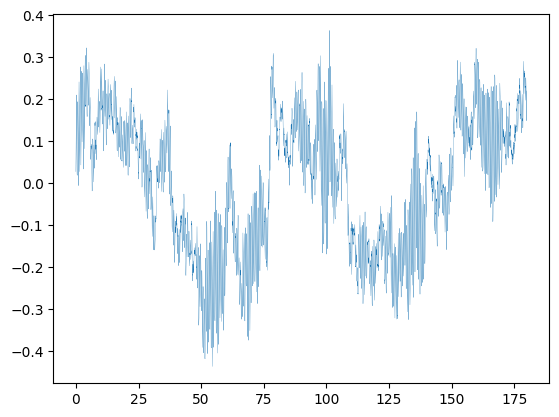

In [78]:
# Create a synthetic sample by drawing from a multivariate normal
K = covfunc(X[:,None], X[:,None].T, covparams)
L =  jla.cholesky(K, lower=True)

key = jrandom.PRNGKey(42)
myrand = jrandom.normal(key, shape=(N,)) 
        
y = L.dot(myrand) 
plt.plot(X,y, lw=0.2)

Text(0.5, 0, 'f [cpd]')

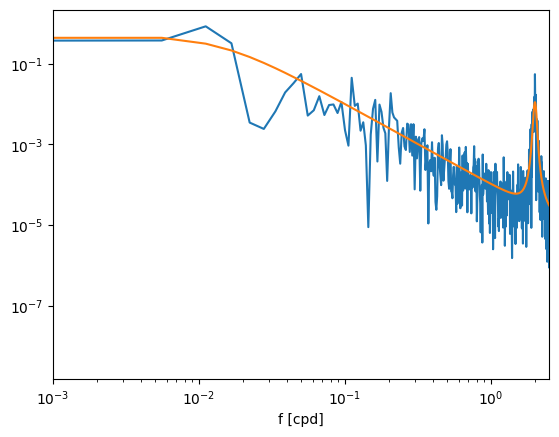

In [79]:
# Plot the periodogram of the time-series data and the parametric spectral profile
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f, I = nsjax.periodogram(y, dt)
# bochner function does the discrete ifft
f_S, S = nsjax.bochner(acf, delta=dt)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

In [89]:
# Parameter estimation using jax
covparams_guess = (0.1, 10, 1.5, 0.1, 10, 1.8)

params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     verbose=True)
print(72*'#')
print('Truth: ', covparams)
print('Estimated: ',params)

step 0, loss: -3627.93310546875
[0.11051702 9.04838    1.357257   0.11051702 9.04838    1.6287084 ]
step 25, loss: -6361.7900390625
[ 0.11697522  7.4227104   0.9620167   0.07964072 15.658767    1.481147  ]
step 50, loss: -6402.4990234375
[ 0.12055681  7.429408    0.9589901   0.07025372 13.612826    1.3347778 ]
step 75, loss: -6418.0390625
[ 0.12468541  7.7201405   1.011885    0.06694977 10.339281    1.3329278 ]
step 100, loss: -6424.306640625
[0.13125812 7.8709483  1.0421009  0.06108988 7.9091105  1.3967972 ]
step 125, loss: -6428.21484375
[0.13578796 8.0597925  1.0533593  0.05544287 6.2727346  1.4739938 ]
step 148, loss: -6429.0126953125
########################################################################
Truth:  (0.15, 12.0, 1.0, 0.05, 5.0, 1.5)
Estimated:  [0.13799752 8.294194   1.0508823  0.05311303 5.622839   1.5193619 ]


In [82]:
# Use a log transformer to put constraints on the parameters

covparams_guess = (0.1, 10, 1.5, 0.1, 10, 1.8)

params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     transformer=nsjax.LogTransformer,
                     verbose=True)

print(72*'#')
print('Truth: ', covparams)
print('Estimated: ',params)

step 0, loss: -3627.93310546875
[0.11051702 9.04838    1.357257   0.11051702 9.04838    1.6287084 ]
step 25, loss: -6361.7900390625
[ 0.11697522  7.4227104   0.9620167   0.07964072 15.658767    1.481147  ]
step 50, loss: -6402.4990234375
[ 0.12055681  7.429408    0.9589901   0.07025372 13.612826    1.3347778 ]
step 75, loss: -6418.0390625
[ 0.12468541  7.7201405   1.011885    0.06694977 10.339281    1.3329278 ]
step 100, loss: -6424.306640625
[0.13125812 7.8709483  1.0421009  0.06108988 7.9091105  1.3967972 ]
step 125, loss: -6428.21484375
[0.13578796 8.0597925  1.0533593  0.05544287 6.2727346  1.4739938 ]
step 148, loss: -6429.0126953125
Truth:  (0.15, 12.0, 1.0, 0.05, 5.0, 1.5)
Estimated:  [0.13799752 8.294194   1.0508823  0.05311303 5.622839   1.5193619 ]


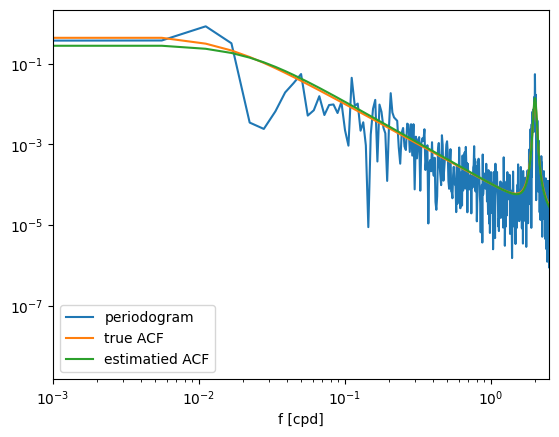

In [91]:
f, I = nsjax.periodogram(y, dt)
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f_S, S = nsjax.bochner(acf, delta=dt)
acf = covfunc(X, X[0], params, **cov_kwargs)
_, S_est = nsjax.bochner(acf, delta=dt)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.loglog(f_S,S_est)

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')
plt.legend(('periodogram','true ACF','estimatied ACF'))